## Задание 2: Фильтрация шума - Решение

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error
import copy

### 1. Загрузка и подготовка исходного изображения

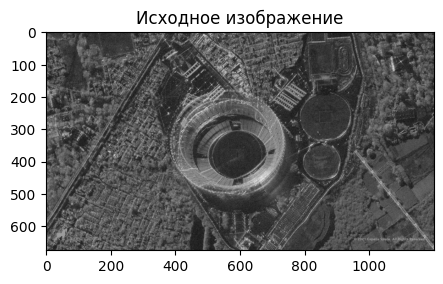

In [2]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 5))
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.show()

### 2. Генерация зашумленных изображений

In [3]:
# Гауссов шум
mean = 0
stddev = 100
noise_gauss_raw = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss_raw, mean, stddev)
image_noise_gauss = cv2.add(image_gray, noise_gauss_raw)

# Шум "Соль и перец"
noise_sp_raw = np.random.randint(0, 101, size=(image_gray.shape[0], image_gray.shape[1]), dtype=int)
zeros_pixel = np.where(noise_sp_raw == 0)
ones_pixel = np.where(noise_sp_raw == 100)
image_sp = copy.deepcopy(image_gray)
image_sp[zeros_pixel] = 0
image_sp[ones_pixel] = 255

### 3. Фильтрация Гауссова шума и оценка результатов

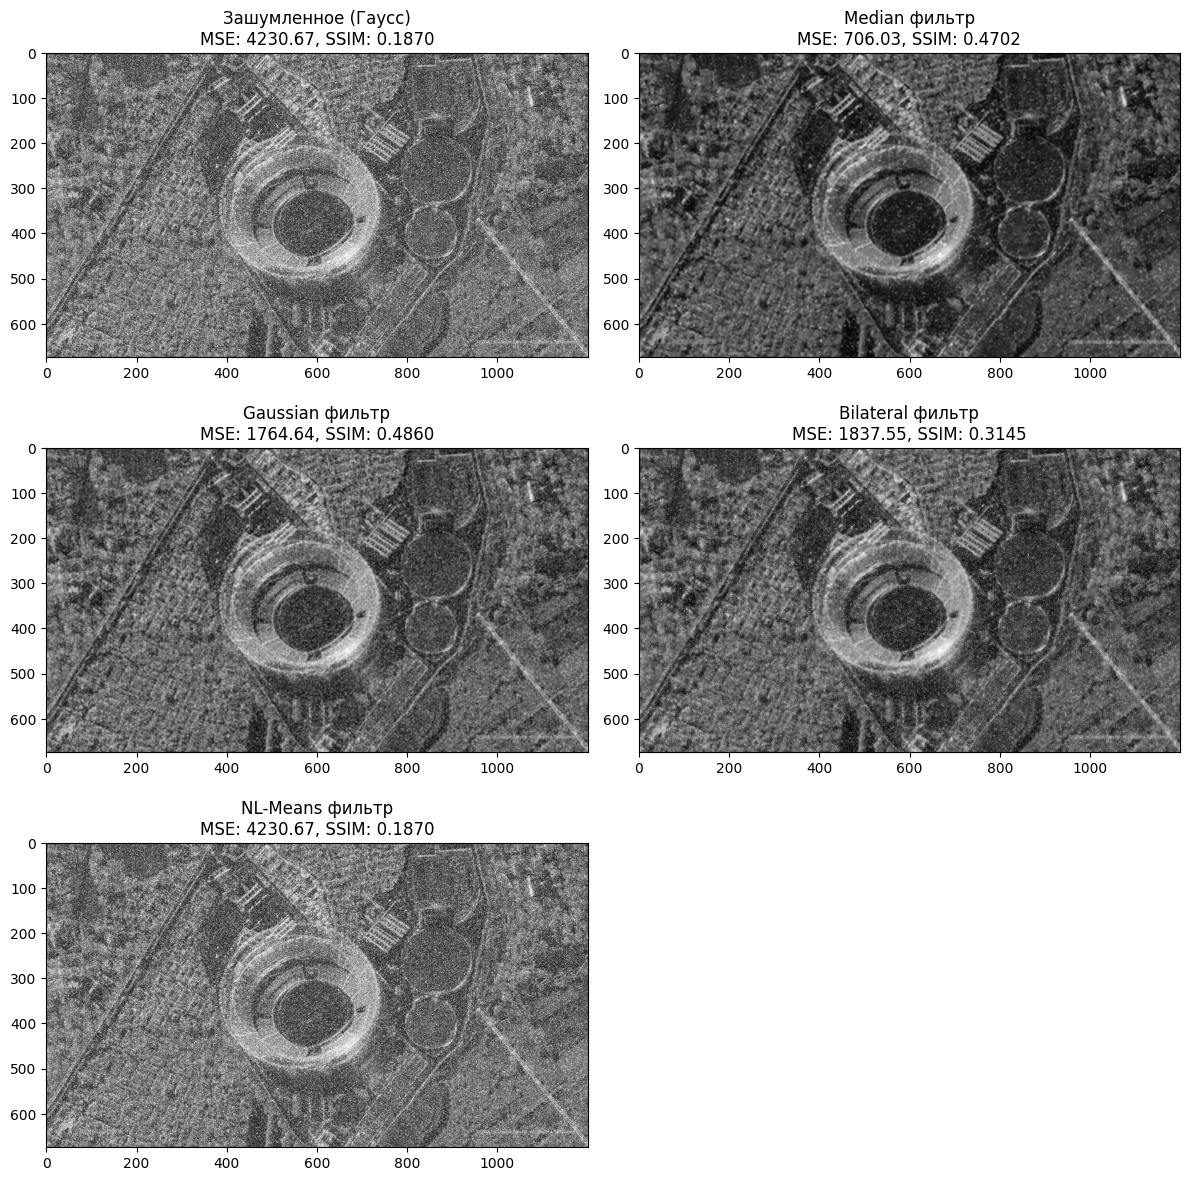

In [4]:
gauss_filters = {
    "Median": lambda img: cv2.medianBlur(img, 5),
    "Gaussian": lambda img: cv2.GaussianBlur(img, (5, 5), 0),
    "Bilateral": lambda img: cv2.bilateralFilter(img, 9, 75, 75),
    "NL-Means": lambda img: cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
}

gauss_results = []
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.imshow(image_noise_gauss, cmap='gray')
plt.title(f"Зашумленное (Гаусс)\nMSE: {mean_squared_error(image_gray, image_noise_gauss):.2f}, SSIM: {structural_similarity(image_gray, image_noise_gauss, full=True)[0]:.4f}")

plot_index = 2
for name, filter_func in gauss_filters.items():
    filtered_img = filter_func(image_noise_gauss)
    mse = mean_squared_error(image_gray, filtered_img)
    ssim, _ = structural_similarity(image_gray, filtered_img, full=True)
    gauss_results.append({"Filter": name, "MSE": mse, "SSIM": ssim})
    
    plt.subplot(3, 2, plot_index)
    plt.imshow(filtered_img, cmap='gray')
    plt.title(f"{name} фильтр\nMSE: {mse:.2f}, SSIM: {ssim:.4f}")
    plot_index += 1

plt.tight_layout()
plt.show()

### 4. Фильтрация шума "Соль и перец" и оценка результатов

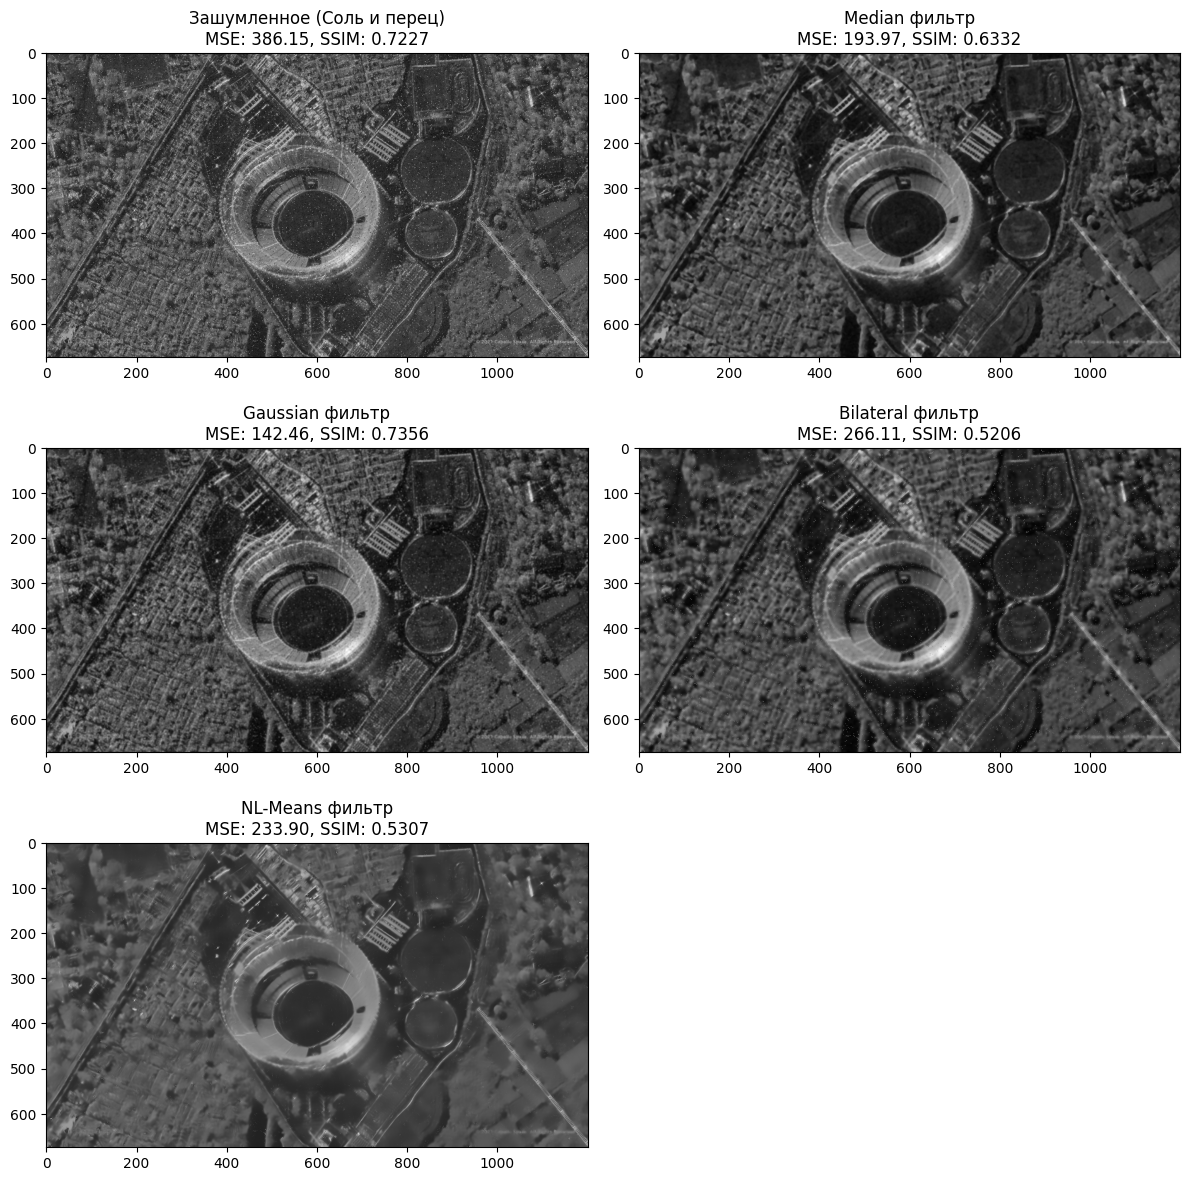

In [5]:
sp_filters = {
    "Median": lambda img: cv2.medianBlur(img, 5),
    "Gaussian": lambda img: cv2.GaussianBlur(img, (5, 5), 0),
    "Bilateral": lambda img: cv2.bilateralFilter(img, 9, 75, 75),
    "NL-Means": lambda img: cv2.fastNlMeansDenoising(img, None, 25, 7, 21) # Увеличим h для лучшего эффекта на S&P
}

sp_results = []
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.imshow(image_sp, cmap='gray')
plt.title(f"Зашумленное (Соль и перец)\nMSE: {mean_squared_error(image_gray, image_sp):.2f}, SSIM: {structural_similarity(image_gray, image_sp, full=True)[0]:.4f}")

plot_index = 2
for name, filter_func in sp_filters.items():
    filtered_img = filter_func(image_sp)
    mse = mean_squared_error(image_gray, filtered_img)
    ssim, _ = structural_similarity(image_gray, filtered_img, full=True)
    sp_results.append({"Filter": name, "MSE": mse, "SSIM": ssim})
    
    plt.subplot(3, 2, plot_index)
    plt.imshow(filtered_img, cmap='gray')
    plt.title(f"{name} фильтр\nMSE: {mse:.2f}, SSIM: {ssim:.4f}")
    plot_index += 1

plt.tight_layout()
plt.show()

### 5. Выводы

Проанализируем полученные метрики для обоих типов шума. Напомним, что для **MSE** чем меньше значение, тем лучше, а для **SSIM** чем ближе к 1, тем лучше.

#### Результаты для Гауссова шума


In [ ]:
import pandas as pd
df_gauss = pd.DataFrame(gauss_results).sort_values(by='MSE', ascending=True)
df_gauss.style.hide_index()

**Вывод по Гауссову шуму:**

Как видно из таблицы и изображений, **Median фильтр** показал себя лучше всего MSE:706 SSIM:0.47, а на втором месте находится **Gaussian фильтр**, который показывает лучшеий результат среди всех MSE:1764 SSIM: 0.486 , кроме **Median фильтра**. Они оба значительно снижают MSE и повышают SSIM. **Median фильтр** дает самый низкий MSE, что говорит о лучшем восстановлении исходных значений пикселей. **Фильтр Гаусса** также неплохо справляется, но сильно уступает в MSE, что компинсируется более высоким SSIM. Хуже всех себя показал **NL-Means фильтр**.

#### Результаты для шума "Соль и перец"


In [ ]:
df_sp = pd.DataFrame(sp_results).sort_values(by='MSE', ascending=True)
df_sp.style.hide_index()

**Вывод по шуму "Соль и перец":**

Здесь ситуация примерно таже. **Gaussian фильтр** является абсолютным победителем. Он демонстрирует на порядок лучшие показатели MSE: 142 и SSIM: 0.7356 по сравнению со всеми остальными фильтрами. На втором месте оказался **Median фильтр** с показателями MSE: 193 и SSIM: 0.6332. Худшим оказался **Bilateral фильтр** с показателями MSE: 266 и SSIM: 0.5206.

### Итоговое заключение

Выбор оптимального фильтра напрямую зависит от природы шума в изображении:
- Для **Гауссова (случайного) шума** наилучшие результаты показывают **Gaussian фильтр** и **Median фильтр**.
- Для **импульсного шума ("Соль и перец")** наилучшие результаты показывают **Median фильтр** и **Gaussian фильтр**.